# Data Exploration - IOB, COB and BG
The notebook 0.01-rd-initial-data-exploration-cob.ipynd was an early attempt to understand COB data, the quality and integrity of it. This notebook will now look at the overall sample of those that we can confidently and easily offset the timestamps (i.e. those that only have only timezone associated), and then drill down to the selected candidates that will be used for the study, based on the criteria set out in 2.01-rd-candidate-selection-analysis.ipynb.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import time
from typing import List, Tuple
from matplotlib import pyplot as plt
from IPython.display import display
from loguru import logger

from src.config import INTERIM_DATA_DIR
from src.sample_filter import SampleFilter
from src.configurations import FifteenMinute, ThirtyMinute

2025-07-26 21:46:37.774 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


## Raw Data Analysis
The raw data is stored in the interim directory, and we will load it to understand the structure and content of the data. This will help us to identify any issues with the data, such as missing values or inconsistencies, and to determine the best approach for cleaning and preprocessing the data.

In [2]:
irregular_df = pd.read_csv(INTERIM_DATA_DIR / 'irregular_iob_cob_bg.csv')
irregular_df['datetime'] = pd.to_datetime(irregular_df['datetime'], format='ISO8601')
irregular_df['date'] = irregular_df['datetime'].dt.date
print(f'Patient count: {irregular_df["id"].nunique()}')
print(f'Number of rows: {irregular_df.shape[0]}')
print(f'Number of unique patient dates: {irregular_df[["id", "date"]].drop_duplicates().shape[0]}')

Patient count: 114
Number of rows: 1056315
Number of unique patient dates: 10193


In [3]:
irreg_stats = irregular_df[['bg', 'iob', 'cob']].describe().T
display(irreg_stats)
irreg_table = irreg_stats.to_latex(
    index=True,
    float_format='%.2f',
    caption='Descriptive statistics of the irregularly sampled data for BG, IOB, and COB.',
    label='tab:irregular_stats',
    header=['Count', 'Mean', 'Std Dev', 'Min', '25%', '50%', '75%', 'Max'],
)
print(irreg_table)

,count,mean,std,min,25%,50%,75%,max
bg,1028030.0,138.284830,50.466897,29.00,102.00,127.000,164.000,489.000
iob,1002671.0,1.611944,2.329427,-8.06,0.14,0.898,2.335,47.567
cob,965094.0,8.554868,18.420240,0.00,0.00,0.000,8.000,223.000


\begin{table}
\caption{Descriptive statistics of the irregularly sampled data for BG, IOB, and COB.}
\label{tab:irregular_stats}
\begin{tabular}{lrrrrrrrr}
\toprule
 & Count & Mean & Std Dev & Min & 25% & 50% & 75% & Max \\
\midrule
bg & 1028030.00 & 138.28 & 50.47 & 29.00 & 102.00 & 127.00 & 164.00 & 489.00 \\
iob & 1002671.00 & 1.61 & 2.33 & -8.06 & 0.14 & 0.90 & 2.33 & 47.57 \\
cob & 965094.00 & 8.55 & 18.42 & 0.00 & 0.00 & 0.00 & 8.00 & 223.00 \\
\bottomrule
\end{tabular}
\end{table}



In [4]:
print(f'Min date: {irregular_df["date"].min()}, Max date: {irregular_df["date"].max()}')

Min date: 2000-01-01, Max date: 2021-04-06


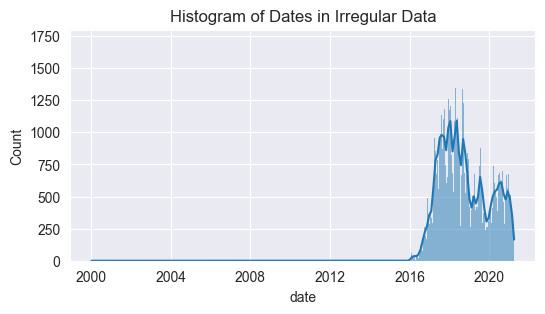

In [5]:
fig = plt.figure(figsize=(6, 3))
sns.histplot(irregular_df['date'], kde=True)
plt.title('Histogram of Dates in Irregular Data')
plt.show()

In [6]:
odd_dates = irregular_df[irregular_df['datetime'].dt.year < 2016]
print('Records with erroneous dates:')
odd_dates.groupby(['id', 'date']).size().sort_values(ascending=False)

Records with erroneous dates:


id        date      
71397255  2000-01-01    2
97417885  2000-01-01    2
dtype: int64

In [7]:
print(f'Earliest date following outlier removal: {irregular_df.drop(index=odd_dates.index)["datetime"].dt.date.min().strftime("%Y-%m-%d")}')

Earliest date following outlier removal: 2016-02-06



## Missingness from resampled data
NOTE: POSSIBLY DELETE. NOT CURRENTLY RUNNING AS NOT WORKING
Resampling data from irregular to regular intervals does not initially carry out imputation of missing values, so we will need to check the number of NaNs in the resampled data. This is important because we want to ensure that the data is complete and that there are no missing values that could affect the analysis. This will guide us on the methods used for analysis, the risks involved in introducing bias, and ultimately the methods used for imputation of missing values if this is strategy we choose to take. The following will analyse the level of missingness in the different resampled levels. in the data. The factors that will vary in the analysis are:
- The resampling interval (15 minutes, 30 minutes)
- The number of consecutive missing intervals (dependent on the resampling interval, e.g. 2 for 30 minutes, 4 for 15 minutes)
- The minimum number of nights (20, 3)
- The start and end times of the night period (e.g. 17:00 to 11:00, 22:00 to 06:00)
- The number of missing intervals (dependent on the resampling interval, e.g. 2 for 30 minutes, 4 for 15 minutes)

In [8]:
def plot_counts(counts: List[Tuple[int, int, int, int]]):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict

    # counts: list of (max_length, missed_intervals, c, n)
    data = defaultdict(lambda: {'intervals': [], 'c': [], 'n': []})
    max_interval = max([i for _, i, _, _ in counts])
    max_candidates = max([c for _, _, c, _ in counts])
    max_nights = max([n for _, _, _, n in counts])
    for max_length, missed_intervals, c, n in counts:
        data[max_length]['intervals'].append(missed_intervals)
        data[max_length]['c'].append(c)
        data[max_length]['n'].append(n)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    color_map = plt.get_cmap('tab10')
    colors = [color_map(i) for i in range(len(data))]

    ax2 = ax1.twinx()

    for idx, (max_length, vals) in enumerate(sorted(data.items())):
        color = colors[idx]
        ax1.plot(vals['intervals'], vals['c'], marker='o', linestyle='-', color=color, label=f'Candidates (max_length={max_length})')
        ax2.plot(vals['intervals'], vals['n'], marker='x', linestyle='--', color=color, label=f'Nights (max_length={max_length})')

    ax1.set_xlabel('Number of Missing Intervals Allowed')
    ax1.set_xticks(np.arange(0, max_interval+1, 1))
    ax1.set_ylabel('Count of Candidates')
    ax1.set_yticks(np.arange(0, max_candidates+1, 2))
    ax2.set_ylabel('Count of Nights')
    ax2.set_yticks(np.arange(0, max_nights+1, 100))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    fig.suptitle('Counts of Candidates and Nights vs Missing Intervals\nGrouped by max_length')
    fig.tight_layout()

    plt.grid()
    plt.show()

In [9]:
def get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,):
    counts = []
    for missed_intervals in interval_range:
        for max_length in break_range:
            sample = SampleFilter(
                    night_start=night_start,
                    morning_end=morning_end,
                    sampling=sampling,
                    missed_intervals=missed_intervals,
                    max_break_run=max_length,
                    min_nights=min_nights,
                )
            c, n = sample.return_counts(logging=False)
            counts.append((max_length, missed_intervals, c, n))
    return counts

In [10]:
# NOTE: At 15 min sampling this takes 14mins
logger.remove()
interval_range = range(0,10)
break_range = [1,2,3]
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = FifteenMinute()
min_nights = 30
missed_intervals = 12

min_counts_a = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)

Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
N

9
6
375


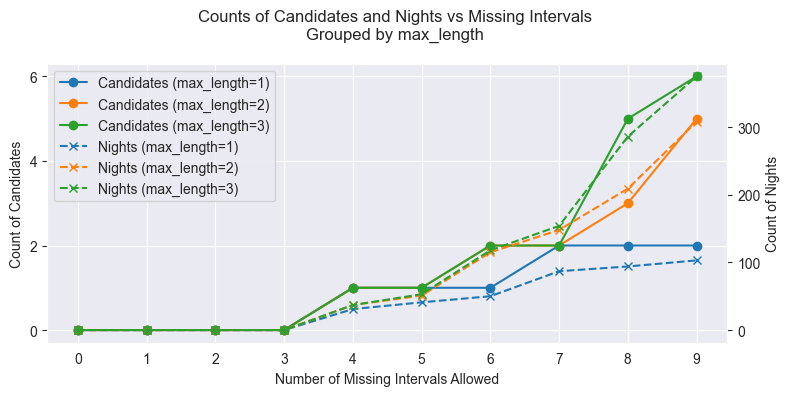

Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, in a range of up to 12 missed intervals allowed.


In [11]:
plot_counts(min_counts_a)
print('Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, in a range of up to 12 missed intervals allowed and 1-3 max consecutive intervals missed.')

Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
N

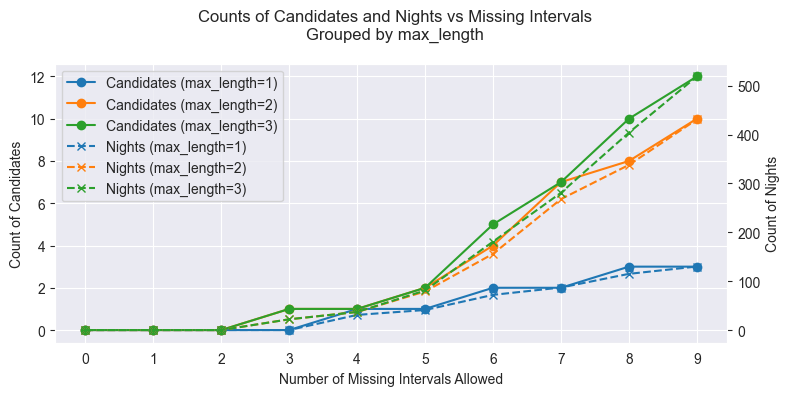

Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, and 12 missed intervals allowed.


In [12]:
# NOTE: At 15 min sampling this takes 12mins
interval_range = range(0,10)
break_range = [1,2,3]
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = FifteenMinute()
min_nights = 20

min_counts_b = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)
plot_counts(min_counts_b)
print('Analysis of number of patients and nights returned at 15 minute sampling with 30 nights minimum, and 12 missed intervals allowed.')

In [ ]:
sampling = ThirtyMinute()
interval_range = range(0,4)
break_range = [1,2]
min_nights = 30
min_counts_b = get_counts(sampling, night_start, morning_end, min_nights, interval_range, break_range,)
plot_counts(min_counts_b)

Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83
Number of nights objects created: 83


It is now also clear that there are individuals with a significant amount of missing data for COB, but not totally missing COB data. This is likely due to the way that COB data is collected and processed, and it is important to note that this may affect the analysis. It will not be possible to cluster these individuals and needs to be another step in the process of selecting candidates. Lets look at the data, and find a criteria to use for selection. First, we can load the data without constraint for the period concerned.

In [14]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 0
missed_intervals = 999
max_break_run = 999
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
)

Number of nights objects created: 83


Then we need to look at understanding the proportion of missing COB data in the sample for individuals and look an acceptable condition for selection. We need to maximise the number of COB values as it will impact the clustering and ability to find patterns with this in mind.

In [15]:
stats = sample.stats[['total_cob_nans', 'total_iob_nans', 'period_total_intervals', 'count_of_nights']].copy()
stats['total_intervals'] = stats['period_total_intervals'] * stats['count_of_nights']
stats['cob_missing_ratio'] = stats['total_cob_nans'] / stats['total_intervals']
stats['iob_missing_ratio'] = stats['total_iob_nans'] / stats['total_intervals']
cob_stats = stats[stats['cob_missing_ratio']>0.1].sort_values(by='cob_missing_ratio', ascending=False)
cob_stats[['count_of_nights','cob_missing_ratio']]

,count_of_nights,cob_missing_ratio
id,,
57176789,322,0.509058
68267781,291,0.467640
99296581,11,0.313131
72492570,36,0.266204
71397255,25,0.220000
41663654,2,0.166667
63725802,2,0.166667
73521474,21,0.125661


In [16]:
iob_stats = stats[stats[('iob_missing_ratio')]>0.00].sort_values(by='iob_missing_ratio', ascending=False)
iob_stats[['count_of_nights','iob_missing_ratio']]

,count_of_nights,iob_missing_ratio
id,,
68267781,291,0.318251
72492570,36,0.191358
63725802,2,0.166667
90398368,8,0.013889


Four patients have any IOB missing, and two of those have less than 30 nights. The other two we would been to drop if they are in our final cut. With COB, there are lots more missing values.